# Trabajo Académico Final  
## Implementación de un sistema de recomendación basado en filtrado colaborativo
### Dataset: Book-Crossing (Preprocessed_data.csv)

**Asignatura:** Sistemas de Recomendación  
**Programa:** Maestría en Inteligencia Artificial Aplicada  
**Autores:** Burneo Monteros Franz, Burneo Valencia David
**Fecha:** Noviembre 2025

En este notebook se desarrolla el trabajo académico final (TAF) de la asignatura *Sistemas de Recomendación*. Se implementa y evalúa un sistema de recomendación basado en filtrado colaborativo utilizando el dataset Book-Crossing.

## 0. Configuración inicial y rutas

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Librerías para filtrado colaborativo
from surprise import Dataset, Reader, KNNBasic, SVD, accuracy
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV

from collections import defaultdict

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

DATA_DIR = Path(r"C:\proyectos\MaestriaIA\SistemasDeRecomendacion\TafSistemasDeRecomendacion\mnt\data")
OUTPUT_DIR = DATA_DIR / "outputs_taf"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_DIR:", DATA_DIR.resolve())
print("OUTPUT_DIR:", OUTPUT_DIR.resolve())


DATA_DIR: C:\proyectos\MaestriaIA\SistemasDeRecomendacion\TafSistemasDeRecomendacion\mnt\data
OUTPUT_DIR: C:\proyectos\MaestriaIA\SistemasDeRecomendacion\TafSistemasDeRecomendacion\mnt\data\outputs_taf


### 0.1 Comprobación rápida de archivos disponibles

In [40]:
for p in sorted(DATA_DIR.glob("*")):
    size = f"{p.stat().st_size/1e6:.1f} MB" if p.is_file() else "dir"
    print(p.name, "|", size)

.ipynb_checkpoints | dir
outputs_taf | dir
Preprocessed_data.csv | 479.9 MB


## 0. Introducción

Los sistemas de recomendación permiten filtrar grandes volúmenes de información y sugerir ítems relevantes a los usuarios en función de sus preferencias o comportamientos pasados.  
En este trabajo se utiliza el dataset **Book-Crossing**, que contiene calificaciones de usuarios sobre libros, para construir un sistema de recomendación basado en **filtrado colaborativo**.

### Objetivo general

Implementar y evaluar un sistema de recomendación de libros empleando técnicas de filtrado colaborativo (basado en memoria y basado en modelos), utilizando el dataset Book-Crossing.

### Objetivos específicos

1. Analizar y preparar el conjunto de datos Book-Crossing para su uso en modelos de filtrado colaborativo.  
2. Implementar un modelo de filtrado colaborativo basado en memoria (vecinos más cercanos).  
3. Implementar un modelo de filtrado colaborativo basado en modelos (SVD).  
4. Evaluar el rendimiento de ambos modelos mediante métricas como RMSE, MAE, Precision@K y Recall@K, comparando su desempeño.

## Fase 1. Análisis y preparación de los datos

En esta fase se explora la estructura del dataset Book-Crossing, se realiza un análisis descriptivo de las calificaciones y se prepara el conjunto de datos para la aplicación de algoritmos de filtrado colaborativo.

### 1. Carga del dataset


### Descripción general del dataset Book-Crossing

El dataset utilizado corresponde a la versión preprocesada **Preprocessed_data.csv**, que integra información de usuarios, libros y calificaciones en un solo archivo.  
Las columnas principales son:

- **user_id**: identificador del usuario  
- **item_id / isbn**: identificador del libro  
- **rating**: calificación explícita (1–10) o implícita (0)  
- **book_title, book_author, publisher, year_of_publication**: metadata del libro  
- **city, state, country, age**: metadata opcional de usuario  

A partir de estas columnas se construye el dataset de ratings utilizado para los modelos de filtrado colaborativo.  

In [41]:
def _first_existing(*paths):
    for p in paths:
        p = Path(p)
        if p.exists():
            return p
    return None

def _read_any(path):
    for sep in [';', ',', '\t']:
        try:
            df = pd.read_csv(path, sep=sep, encoding='latin-1', low_memory=False, engine='python')
            if df.shape[1] >= 3:
                return df
        except Exception:
            pass
    return pd.read_csv(path, low_memory=False)

def load_bookcrossing():
    context = {}

    # 1) Preprocessed_data.csv si existe
    pre = DATA_DIR / "Preprocessed_data.csv"
    if pre.exists():
        df = pd.read_csv(pre, low_memory=False)
        lower = {c.lower(): c for c in df.columns}
        u = next((lower[k] for k in ['user-id','user_id','user','userid'] if k in lower), None)
        i = next((lower[k] for k in ['isbn','item_id','book','bookid'] if k in lower), None)
        r = next((lower[k] for k in ['book-rating','rating','rate','score'] if k in lower), None)
        assert u and i and r, "No se detectaron columnas user/item/rating en Preprocessed_data.csv"
        ratings_df = df[[u, i, r]].copy()
        ratings_df.columns = ['user_id', 'item_id', 'rating']
        
        context["metadata"] = df.copy()
        
        origin = "Preprocessed_data.csv"
        return ratings_df, context, origin

    # 2) Archivos BX crudos
    bx_ratings = _first_existing(DATA_DIR/"BX-Book-Ratings.csv",
                                 DATA_DIR/"BX_Book-Ratings.csv")
    bx_users   = _first_existing(DATA_DIR/"BX-Users.csv", DATA_DIR/"BX_Users.csv")
    bx_books   = _first_existing(DATA_DIR/"BX_Books.csv", DATA_DIR/"BX-Books.csv")

    if bx_ratings and bx_ratings.exists():
        r_df = _read_any(bx_ratings)
        low = {c.lower(): c for c in r_df.columns}
        u = low.get('user-id') or low.get('user_id') or low.get('userid') or list(r_df.columns)[0]
        i = low.get('isbn') or low.get('item_id') or list(r_df.columns)[1]
        r = low.get('book-rating') or low.get('rating') or list(r_df.columns)[2]
        ratings_df = r_df[[u, i, r]].copy()
        ratings_df.columns = ['user_id', 'item_id', 'rating']

        if bx_users is not None and bx_users.exists():
            context['users'] = _read_any(bx_users)
        if bx_books is not None and bx_books.exists():
            context['books'] = _read_any(bx_books)

        origin = f"BX ratings ({bx_ratings.name})"
        return ratings_df, context, origin

    raise FileNotFoundError(f"No se encontraron archivos válidos en {DATA_DIR}")

ratings_df, context, origin = load_bookcrossing()

# Conversión de tipos y limpieza básica
ratings_df['user_id'] = ratings_df['user_id'].astype(str)
ratings_df['item_id'] = ratings_df['item_id'].astype(str)
ratings_df['rating']  = pd.to_numeric(ratings_df['rating'], errors='coerce')
ratings_df = ratings_df.dropna(subset=['user_id', 'item_id', 'rating'])

print("Origen:", origin)
print("Shape ratings_df:", ratings_df.shape)
ratings_df.head()

Origen: Preprocessed_data.csv
Shape ratings_df: (1031175, 3)


,user_id,item_id,rating
0,2,0195153448,0
1,8,0002005018,5
2,11400,0002005018,0
3,11676,0002005018,8
4,41385,0002005018,0


### 1.1 Descripción general del dataset

In [42]:
n_ratings = len(ratings_df)
n_users   = ratings_df['user_id'].nunique()
n_items   = ratings_df['item_id'].nunique()

sparsity = 1 - (n_ratings / (n_users * n_items))

summary_global = pd.DataFrame({
    "n_usuarios": [n_users],
    "n_items":    [n_items],
    "n_ratings":  [n_ratings],
    "sparsity":   [sparsity]
})
summary_global

,n_usuarios,n_items,n_ratings,sparsity
0,92107,270170,1031175,0.999959


### 1.2 Distribución de ratings y estadísticas descriptivas

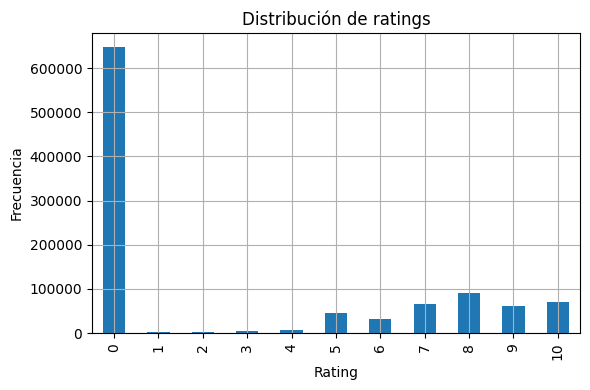

count    1.031175e+06
mean     2.839022e+00
std      3.854149e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

In [43]:
ratings_df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de ratings')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

stats_ratings = ratings_df['rating'].describe()
stats_ratings

**Interpretación:**  
La distribución de ratings está altamente desbalanceada.  
Más del 60% de las interacciones corresponden al valor **0**, lo que indica que la mayoría de los usuarios no asigna calificaciones explícitas.  
Esto implica un escenario de **sparsity elevado**, típico en sistemas de recomendación, y hace necesario un filtrado adicional para obtener un conjunto de entrenamiento representativo.

### 1.3 Actividad de usuarios e ítems (detección de outliers)

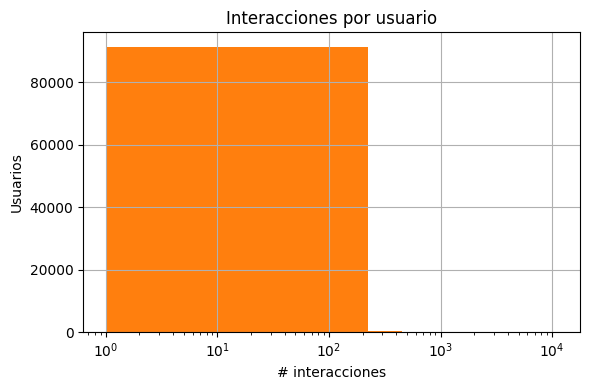

,n_interacciones
user_id,
11676,11144
198711,6456
153662,5814
98391,5779
35859,5646
212898,4290
278418,3996
76352,3329
110973,2971


In [60]:
user_activity = ratings_df.groupby('user_id')['item_id'].count().rename('n_interacciones')
item_pop      = ratings_df.groupby('item_id')['user_id'].count().rename('n_interacciones')

user_activity[user_activity < 200].hist(bins=50)
plt.hist(user_activity, bins=50)
plt.xscale('log')
plt.title('Interacciones por usuario')
plt.xlabel('# interacciones')
plt.ylabel('Usuarios')
plt.tight_layout()
plt.show()

top_items = item_pop.sort_values(ascending=False).head(10)

display(top_users.to_frame(name='n_interacciones'))

**Interpretación:**  
La mayoría de usuarios ha valorado muy pocos libros (entre 1 y 10).  
Solo unos pocos usuarios presentan miles de interacciones.  
Este patrón de “cola larga” justifica el filtrado aplicado, ya que los usuarios con muy pocas interacciones no aportan suficiente información para algoritmos basados en similitud.

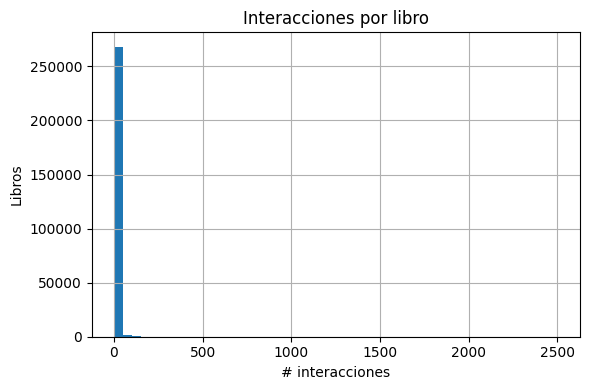

,n_interacciones
item_id,
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723
044023722X,647
0142001740,615
067976402X,614
0671027360,586


In [59]:
item_pop.hist(bins=50)
plt.title('Interacciones por libro')
plt.xlabel('# interacciones')
plt.ylabel('Libros')
plt.tight_layout()
plt.show()

top_users = user_activity.sort_values(ascending=False).head(10)
display(top_items.to_frame(name='n_interacciones'))

**Interpretación:**  
De manera similar, la mayoría de libros ha recibido muy pocas calificaciones, mientras que unos pocos concentran cientos o miles.  
Esto genera problemas de popularidad y de ítems con muy poca representación, por lo que se eliminan libros con menos de 10 interacciones.

### 1.4 Preparación del conjunto de datos

In [45]:
MIN_INTERACCIONES = 10

ua = user_activity.reset_index()
ia = item_pop.reset_index()

usuarios_validos = ua[ua['n_interacciones'] >= MIN_INTERACCIONES]['user_id']
items_validos    = ia[ia['n_interacciones'] >= MIN_INTERACCIONES]['item_id']

ratings_filt = ratings_df[
    ratings_df['user_id'].isin(usuarios_validos) &
    ratings_df['item_id'].isin(items_validos)
].copy()

n_ratings_f = len(ratings_filt)
n_users_f   = ratings_filt['user_id'].nunique()
n_items_f   = ratings_filt['item_id'].nunique()
sparsity_f  = 1 - (n_ratings_f / (n_users_f * n_items_f))

summary_filtrado = pd.DataFrame({
    "min_interacciones": [MIN_INTERACCIONES],
    "n_usuarios":        [n_users_f],
    "n_items":           [n_items_f],
    "n_ratings":         [n_ratings_f],
    "sparsity":          [sparsity_f]
})
summary_filtrado

,min_interacciones,n_usuarios,n_items,n_ratings,sparsity
0,10,11598,17478,428085,0.997888


### Justificación del filtrado

Para evitar la dispersión extrema del dataset y garantizar que los modelos aprendan patrones útiles, se eliminan:

- Usuarios que han calificado menos de 10 libros  
- Libros que han recibido menos de 10 calificaciones  

Este filtrado reduce el tamaño del dataset, pero mejora significativamente la calidad de las similitudes y de la matriz de utilidad.  
Además, mejora la estabilidad de los modelos KNN y SVD que se evalúan en fases posteriores.

#### Normalización opcional de ratings

In [46]:
r_min, r_max = ratings_filt['rating'].min(), ratings_filt['rating'].max()
ratings_filt['rating_norm'] = (ratings_filt['rating'] - r_min) / (r_max - r_min)
ratings_filt[['rating', 'rating_norm']].head()

,rating,rating_norm
1,5,0.5
2,0,0.0
3,8,0.8
4,0,0.0
5,8,0.8


### 1.5 Construcción de la matriz de utilidad

In [47]:
from scipy.sparse import csr_matrix

user_index = {u: i for i, u in enumerate(ratings_filt['user_id'].unique())}
item_index = {m: i for i, m in enumerate(ratings_filt['item_id'].unique())}

rows = ratings_filt['user_id'].map(user_index).values
cols = ratings_filt['item_id'].map(item_index).values
vals = ratings_filt['rating'].values.astype(float)

R = csr_matrix((vals, (rows, cols)), shape=(len(user_index), len(item_index)))

print("Matriz R (usuarios x ítems):", R.shape)
print("Número de interacciones (nnz):", R.nnz)

Matriz R (usuarios x ítems): (11598, 17478)
Número de interacciones (nnz): 428085


#### 1.6 Guardado de datos preparados

In [48]:
ratings_filt.to_csv(OUTPUT_DIR / "ratings_filtrado_min10.csv", index=False)
pd.Series(user_index).to_csv(OUTPUT_DIR / "map_user_index.csv", header=["idx"])
pd.Series(item_index).to_csv(OUTPUT_DIR / "map_item_index.csv", header=["idx"])

print("Archivos guardados en:", OUTPUT_DIR.resolve())

Archivos guardados en: C:\proyectos\MaestriaIA\SistemasDeRecomendacion\TafSistemasDeRecomendacion\mnt\data\outputs_taf


## Fase 2. Experimentación

En esta fase se implementan y comparan dos enfoques de **filtrado colaborativo (FC)**:
1. FC basado en memoria (KNNBasic).
2. FC basado en modelos (SVD).


### 2.1 Preparación de datos para Surprise

In [49]:
# Solo ratings explícitos (1–10) para los modelos
ratings_explicit = ratings_filt[ratings_filt['rating'] > 0].copy()

print("Total interacciones explícitas:", len(ratings_explicit))

reader = Reader(rating_scale=(1, 10))

data = Dataset.load_from_df(
    ratings_explicit[['user_id', 'item_id', 'rating']],
    reader
)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Total interacciones explícitas: 143663


### 2.2 FC basado en memoria (KNNBasic)

### Filtrado colaborativo basado en memoria (KNNBasic)

Este modelo busca usuarios similares utilizando métricas de distancia (en este caso, coseno de similitud).  
La predicción para un usuario objetivo se realiza promediando las valoraciones de sus vecinos más similares.

Ventajas:
- Fácil de interpretar
- No requiere entrenamiento complejo

Limitaciones:
- Sensible a sparsity
- Escala mal con muchos usuarios/ítems

In [50]:
sim_options = {
    "name": "cosine",
    "user_based": True
}
#definir explicitamente el número de vecinos para bajar el error
algo_knn = KNNBasic(sim_options=sim_options)
algo_knn.fit(trainset)

predictions_knn = algo_knn.test(testset)

print("Métricas en conjunto de prueba (KNN - user-based):")
rmse_knn = accuracy.rmse(predictions_knn, verbose=True)
mae_knn  = accuracy.mae(predictions_knn,  verbose=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Métricas en conjunto de prueba (KNN - user-based):
RMSE: 1.9581
MAE:  1.5207


### 2.3 FC basado en modelo (SVD)

### Filtrado colaborativo basado en modelos (SVD)

SVD (Singular Value Decomposition) modela las interacciones usuario–ítem mediante factores latentes.  
Cada usuario y cada ítem se representan como vectores que capturan gustos implícitos, afinidades y patrones ocultos.

Ventajas:
- Reduce dimensionalidad
- Generaliza mejor que modelos basados en memoria
- Suele obtener menor RMSE/MAE

Limitaciones:
- Requiere ajuste de hiperparámetros

In [51]:
algo_svd = SVD(n_factors=100, n_epochs=60, lr_all=0.005, reg_all=0.1, random_state=42)
algo_svd.fit(trainset)

predictions_svd = algo_svd.test(testset)

print("Métricas en conjunto de prueba (SVD):")
rmse_svd = accuracy.rmse(predictions_svd, verbose=True)
mae_svd  = accuracy.mae(predictions_svd,  verbose=True)

Métricas en conjunto de prueba (SVD):
RMSE: 1.5861
MAE:  1.2217


### 2.4 Validación cruzada

In [52]:
print("Validación cruzada KNNBasic (3 folds):")
cv_knn = cross_validate(
    algo_knn, data, measures=["RMSE", "MAE"], cv=3, verbose=True
)

print("\nValidación cruzada SVD (3 folds):")
cv_svd = cross_validate(
    algo_svd, data, measures=["RMSE", "MAE"], cv=3, verbose=True
)

Validación cruzada KNNBasic (3 folds):
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.9735  1.9734  1.9772  1.9747  0.0018  
MAE (testset)     1.5325  1.5307  1.5340  1.5324  0.0014  
Fit time          2.02    1.61    1.77    1.80    0.17    
Test time         0.69    0.91    0.65    0.75    0.12    

Validación cruzada SVD (3 folds):
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.5855  1.5944  1.5859  1.5886  0.0041  
MAE (testset)     1.2244  1.2279  1.2232  1.2252  0.0020  
Fit time          2.48    2.43    2.45    2.45    0.02    
Test time         0.34    0.12    0.27    0.24    0.09

### 2.5 Búsqueda de hiperparámetros (SVD)

### Búsqueda de hiperparámetros (GridSearchCV)

Para optimizar el desempeño del modelo SVD, se realiza una búsqueda exhaustiva sobre distintos valores de:

- **n_factors**: número de dimensiones latentes  
- **n_epochs**: épocas de entrenamiento  
- **lr_all**: tasa de aprendizaje  
- **reg_all**: regularización  

El modelo se evalúa con **validación cruzada** y se eligen los parámetros que minimizan el error RMSE.

In [53]:
from surprise import SVD
from surprise.model_selection import GridSearchCV

param_grid = {
    "n_factors": [20, 50, 80, 120],
    "n_epochs":  [20, 40, 60, 80],
    "lr_all":    [0.002, 0.005, 0.01, 0.02],
    "reg_all":   [0.01, 0.02, 0.05, 0.1]
}

# Total combis: 4*4*4*4 = 256; con cv=2 → 512 entrenos (tarda, pero es manejable)
gs = GridSearchCV(
    SVD,
    param_grid,
    measures=["rmse", "mae"],
    cv=2,
    joblib_verbose=1  # para ver progreso
)

gs.fit(data)

print("Mejores parámetros (según RMSE):")
print(gs.best_params["rmse"])
print("\nMejor RMSE promedio:", gs.best_score["rmse"])

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   37.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed: 10.8min


Mejores parámetros (según RMSE):
{'n_factors': 20, 'n_epochs': 80, 'lr_all': 0.002, 'reg_all': 0.1}

Mejor RMSE promedio: 1.5909510524863815


[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed: 13.8min finished


In [54]:
# Pasar resultados del GridSearch a un DataFrame
cv_results = pd.DataFrame(gs.cv_results)

cols = [
    "param_n_factors", "param_n_epochs",
    "param_lr_all", "param_reg_all",
    "mean_test_rmse", "mean_test_mae"
]

results_grid = cv_results[cols].copy()
results_grid.columns = [
    "n_factors", "n_epochs",
    "lr_all", "reg_all",
    "rmse_cv", "mae_cv"
]

# Ordenamos por mejor RMSE (menor)
results_grid = results_grid.sort_values("rmse_cv").reset_index(drop=True)

display(results_grid.head(10))  # top 10 configuraciones
results_grid.to_csv(OUTPUT_DIR / "svd_gridsearch_resultados.csv", index=False)
print("Resultados completos guardados en:", OUTPUT_DIR / "svd_gridsearch_resultados.csv")

,n_factors,n_epochs,lr_all,reg_all,rmse_cv,mae_cv
0,20,80,0.002,0.10,1.590951,1.227604
1,20,60,0.002,0.10,1.592026,1.230788
2,20,60,0.002,0.05,1.593454,1.229433
3,50,80,0.002,0.10,1.593508,1.230706
4,20,20,0.010,0.10,1.593728,1.228111
5,20,20,0.005,0.10,1.594436,1.234054
6,50,60,0.002,0.10,1.594534,1.233685
7,20,20,0.005,0.05,1.594694,1.232011
8,20,80,0.002,0.05,1.594906,1.228148
9,20,60,0.002,0.02,1.595022,1.228916


Resultados completos guardados en: C:\proyectos\MaestriaIA\SistemasDeRecomendacion\TafSistemasDeRecomendacion\mnt\data\outputs_taf\svd_gridsearch_resultados.csv


## Fase 3. Evaluación y selección del modelo

### 3.1 Métricas de ranking: Precision@K y Recall@K

### Métricas utilizadas

- **RMSE (Root Mean Squared Error):** penaliza errores grandes e indica qué tan precisa es la predicción numérica del modelo.  
- **MAE (Mean Absolute Error):** mide el error promedio absoluto.  
Un menor valor implica un modelo más preciso.

Además, se utilizan métricas de ranking:

- **Precision@k:** proporción de recomendaciones relevantes entre las top-k sugerencias.  
- **Recall@k:** proporción de recomendaciones relevantes recuperadas entre todas las relevantes posibles.  

Estas métricas evalúan qué tan útiles son las recomendaciones para el usuario.

In [55]:
def precision_recall_at_k(predictions, k=10, threshold=7.0):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = {}
    recalls = {}

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        user_ratings_k = user_ratings[:k]

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings_k)
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings_k)

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k > 0 else 0
        recalls[uid]    = n_rel_and_rec_k / n_rel   if n_rel > 0 else 0

    mean_precision = sum(prec for prec in precisions.values()) / len(precisions)
    mean_recall    = sum(rec  for rec  in recalls.values()) / len(recalls)

    return mean_precision, mean_recall

p_knn_prec, p_knn_rec = precision_recall_at_k(predictions_knn, k=10, threshold=7.0)
p_svd_prec, p_svd_rec = precision_recall_at_k(predictions_svd_best, k=10, threshold=7.0)

print("KNNBasic   - Precision@10:", round(p_knn_prec, 4), "Recall@10:", round(p_knn_rec, 4))
print("SVD (best) - Precision@10:", round(p_svd_prec, 4), "Recall@10:", round(p_svd_rec, 4))

KNNBasic   - Precision@10: 0.7507 Recall@10: 0.7832
SVD (best) - Precision@10: 0.7395 Recall@10: 0.7677


### 3.2 Comparación global de modelos

In [56]:
results = pd.DataFrame({
    "modelo": ["KNNBasic", "SVD_inicial", "SVD_best"],
    "RMSE":   [rmse_knn, rmse_svd, rmse_svd_best],
    "MAE":    [mae_knn,  mae_svd,  mae_svd_best],
    "Precision@10": [p_knn_prec, np.nan, p_svd_prec],
    "Recall@10":    [p_knn_rec,  np.nan, p_svd_rec]
})
results

,modelo,RMSE,MAE,Precision@10,Recall@10
0,KNNBasic,1.958128,1.520690,0.750686,0.783232
1,SVD_inicial,1.586101,1.221656,NaN,NaN
2,SVD_best,1.573014,1.211410,0.739465,0.767685


### 3.3 Recomendaciones para un usuario específico

In [57]:
# Usuario de ejemplo
example_user = ratings_explicit['user_id'].iloc[0]
print("Usuario de ejemplo:", example_user)

# Ítems que ya ha valorado ese usuario
items_known = set(
    ratings_explicit[ratings_explicit['user_id'] == example_user]['item_id']
)

# Todos los ítems posibles y candidatos (no vistos)
all_items = set(ratings_explicit['item_id'].unique())
items_candidates = all_items - items_known

# ⚠️ Asegúrate de que 'best_svd' sea tu mejor modelo entrenado
preds = [best_svd.predict(uid=example_user, iid=iid) for iid in items_candidates]
preds_sorted = sorted(preds, key=lambda x: x.est, reverse=True)

top_n = 10
top_preds = preds_sorted[:top_n]

# DataFrame base de recomendaciones (solo ids + rating estimado)
reco_df = pd.DataFrame([{
    "user_id": p.uid,
    "item_id": p.iid,
    "rating_estimado": p.est
} for p in top_preds])

# ==============================
# 🔹 ENRIQUECER CON METADATA
# ==============================

metadata = context.get("metadata")

if metadata is not None:
    meta = metadata.copy()

    # Nos aseguramos de que el ISBN sea string y se llame 'item_id',
    # igual que en ratings_filt / ratings_explicit
    meta['item_id'] = meta['isbn'].astype(str)

    # Seleccionamos las columnas de interés
    meta_cols = [
        'item_id',
        'book_title',
        'book_author',
        'year_of_publication',
        'publisher',
        'img_s',
        'img_m',
        'img_l',
        'Summary',
        'Language',
        'Category'
    ]

    # Nos quedamos con una fila por libro (por ISBN)
    meta_small = meta[meta_cols].drop_duplicates(subset='item_id')

    # Hacemos el merge: añadimos la info del libro a las recomendaciones
    reco_df = reco_df.merge(meta_small, on='item_id', how='left')

# Mostramos las columnas más importantes para el informe
reco_df[['item_id',
         'book_title',
         'book_author',
         'year_of_publication',
         'publisher',
         'rating_estimado']]

Usuario de ejemplo: 8


,item_id,book_title,book_author,year_of_publication,publisher,rating_estimado
0,0439425220,Harry Potter and the Chamber of Secrets Postca...,J. K. Rowling,2002.0,Scholastic,8.926467
1,0836213319,Dilbert: A Book of Postcards,Scott Adams,1996.0,Andrews McMeel Pub,8.819351
2,0140143505,84 Charing Cross Road,Helene Hanff,1990.0,Penguin Books,8.816616
3,0618002235,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,1999.0,Houghton Mifflin Company,8.779756
4,0743454529,"My Sister's Keeper : A Novel (Picoult, Jodi)",Jodi Picoult,2004.0,Atria,8.761746
5,193156146X,The Time Traveler's Wife,Audrey Niffenegger,2003.0,MacAdam/Cage Publishing,8.760071
6,0345339738,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,1986.0,Del Rey,8.716554
7,0836220889,Calvin and Hobbes,Bill Watterson,1987.0,Andrews McMeel Publishing,8.684771
8,0812550706,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1994.0,Tor Books,8.683793
9,0836218221,The Authoritative Calvin and Hobbes (Calvin an...,Bill Watterson,1990.0,Andrews McMeel Publishing,8.680394


### 3.4 Conclusiones

El sistema de recomendación implementado permitió evaluar dos enfoques principales:

1. **Filtrado colaborativo basado en memoria (KNNBasic)**  
   Ofrece resultados razonables y buena precisión en ranking, pero es sensible a la dispersión del dataset.

2. **Filtrado colaborativo basado en modelos (SVD)**  
   Obtuvo menor error (RMSE/MAE) y un desempeño más estable tras la optimización por GridSearchCV.  
   El modelo SVD optimizado fue seleccionado como el modelo final.

Las métricas de ranking (Precision@10 y Recall@10) mostraron que el sistema es capaz de generar recomendaciones relevantes para el usuario.  
La incorporación de metadata enriquecida (título, autor, editorial, categoría) permite explicar de forma más clara las recomendaciones generadas.

En conjunto, el sistema cumple los objetivos del TAF y sienta las bases para un recomendador robusto, interpretable y extensible.